In [18]:
import abtem
import numpy as np
import matplotlib.pyplot as plt

from abtem import config
config.set({'local_diagnostics.progress_bar': False}) # disable progress bar to avoid cluttering

# Wave functions
The multislice algorithm works by propagating the $xy$ part of the wave function (defined as $\phi$ in the [appendix](appendix/multislice_derivation.ipynb)) through the electrostatic potential. However, before this process, we need to define the wave function describing the incoming electron beam, i.e. the assumed initial conditions of the multislice simulation.

abTEM defines three types of wave functions:

* [`PlaneWave`](wave_functions:plane_wave): Simulate HRTEM, SAED or other imaging modes with plane wave illumination.
* [`Probe`](wave_functions:probe): Simulate CBED, STEM, 4D-STEM or other imaging modes with a converged electron beam.
* [`Waves`](wave_functions:waves): Defines any custom wave function. The `PlaneWave` and `Probe` can be turned into `Waves`.


```{seealso}
The PRISM `SMatrix` is not included in the list above. However, it can be used to achieve most of the goals of using the `Probe`. See our introduction to PRISM in abTEM.
```

(wave_functions:plane_wave)=
## Plane wave functions

We create a plane wave on a $256 \times 256$ grid with a lateral extent of $5\times 5$ $\mathrm{Å}^2$ and an energy of $300 \ \mathrm{keV}$.

In [19]:
waves = abtem.PlaneWave(gpts=256, extent=5, energy=300e3)

The real-space sampling, or pixel size, is calculated by dividing the `extent` by the number of `grid points`. The properties related to the grid, i.e. the `extent`, grid points (`gpts`) and `sampling` can be accessed as:

In [20]:
waves.extent, waves.gpts, waves.sampling

((5.0, 5.0), (256, 256), (0.01953125, 0.01953125))

The grid is fully defined from just two of the three quantities listed above, hence, we may pick any combination of two to define the grid. 

The relativistic wavelength in Ångstrom, derived from the energy, is accessed as:

In [5]:
waves.wavelength

0.01968748889772767

```{note}
abTEM uses the same unit conventions as ASE, as defined in the `ase.units` module. Thus, electron volts (eV), Ångström (Å), and atomic mass units are defined as 1.0. The electrostatic potential is given in (eV / e). Angles in abTEM are for convenience given in milliradians (mrad).

```
We can turn the `PlaneWave` into the generic `Waves` using the `.build` method.

In [21]:
waves = waves.build()

The `Waves` describe the wave function as a complex `dask` array accessed below:

In [22]:
waves.array

dask.array<_extract_measurement, shape=(256, 256), dtype=complex64, chunksize=(256, 256), chunktype=numpy.ndarray>

The `Waves` are computed using the `.compute` method, this turns the `dask` array into a `numpy` array:

In [23]:
waves.compute()

By default the plane wave is just an array of ones:

In [24]:
waves.array

array([[1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
       ...,
       [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j]],
      dtype=complex64)

```{note}
In the above, the plane wave was normalized to be one in every grid point, i.e. the intensity per area is constant when the grid is changed. This is not always the natural choice, see the [appendix](appendix/normalization.ipynb) for more information on wave function normalization in abTEM.
```

(wave_functions:probe)=
## Probe wave functions

In abTEM, a focused beam of electrons, or "probe", is defined in Fourier space as

$$
    \hat{\phi}(\vec{k}) = A(\vec{k}) \ \exp(-i \chi(\vec{k})) \quad ,
$$

where $A(k)$ is the aperture function and $\chi(k_y, k_y)$ is the phase error and $\vec{k} = (k_x, k_y)$ is the spatial frequency in $x$ and $y$, respectively. The real-space probe is just the Fourier transform

$$
    \phi(\vec{r}) = \mathcal{F} \hat{\phi}(\vec{r})
$$

where $\vec{r} = (x, y)$ is the real space coordinate in $x$ and $y$, respectively.


```{seealso}
The phase error is introduced in detail during our discussion on the Contrast Transfer Function.
```

We create a probe with a sampling of $0.05 \ \mathrm{Å}$, an extent of $10\times 10$ $\mathrm{Å}^2$, an energy of $60 \ \mathrm{keV}$, a convergence semiangle of $30 \ \mathrm{mrad}$ and defocus of $50 \ \mathrm{Å}$. 

In [25]:
probe = abtem.Probe(sampling = 0.05, 
                    extent = 10, 
                    energy = 100e3, 
                    semiangle_cutoff = 30,
                    defocus = 35,
                   )

The `Probe` may also be turned into `Waves` using the `.build` method

In [26]:
probe.build().array

dask.array<getitem, shape=(200, 200), dtype=complex64, chunksize=(200, 200), chunktype=numpy.ndarray>

We show the intensity of the probe in Fourier and real space below (i.e. $\|\hat{\phi}\|^2$ and $\|\phi\|^2$), respectively

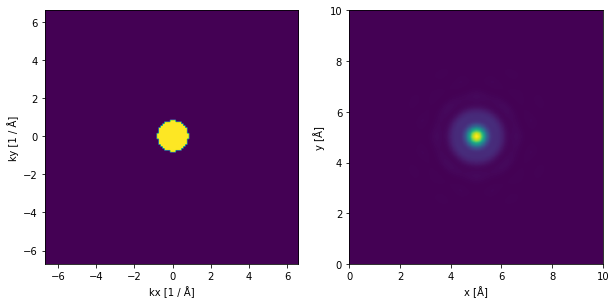

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

probe.build().diffraction_patterns().show(ax=ax1)
probe.build().intensity().show(ax=ax2);

A final important remark is that the `Probe`, is normalized such that its intensity sums to one in Fourier space. This normalization is useful when applying methods that integrates over a part of Fourier space (e.g. HAADF).

In [28]:
probe.build(lazy=False).diffraction_patterns().sum()

1.0

## Measuring the wave function

As you know, we cannot measure the wave function in an experiment. Above, we introduced the methods `.intensity` and `diffraction_patterns` without a full explanation. These methods turns the wave function into a "measurement-type" object, in this case `Images` and `DiffractionPatterns`, respectively. abTEM implements several more "measurement-type" objects which will in detail later.

In [35]:
images = probe.build().intensity()
diffraction_patterns = probe.build().diffraction_patterns()

images, diffraction_patterns

(<abtem.measure.measure.Images at 0x2175b92bac0>,
 <abtem.measure.measure.DiffractionPatterns at 0x217596e7af0>)

Each measurement type provides different methods for post-processing and analysis. A relevant example is to create lineprofile from the image of the 

<AxesSubplot:xlabel='r [Å]'>

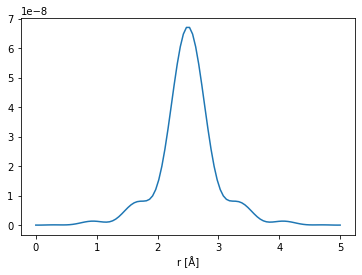

In [36]:
lineprofile = images.interpolate_line_at_position(center=(5,5), angle=0, extent=5)

lineprofile.show()

## Wave function ensembles

abTEM relies on representing multiple distinct wave functions as an ensemble of wave functions. 

As an example, we can create an ensemble of the same wavefunction as mutiple different positions


We can build a batch of three probes at different positions.

In [19]:
positions = [(0, 0), (2.5, 2.5), (5, 5)]

waves = probe.build(positions, lazy=True)

waves.array

dask.array<_extract_measurement, shape=(3, 200, 200), dtype=complex64, chunksize=(3, 200, 200), chunktype=numpy.ndarray>

The last two dimensions of the `Waves` represent the spatial dimensions, we also call these the *base* dimensions of the `Waves`. Any dimension preceeding the base dimensions are called the *ensemble* dimensions, you can read about how abTEM uses the concept of ensembles [here]().

All ensemble dimensions may be sliced. However, slicing a base dimension will throw an error.

In [20]:
wave = waves[1]

wave.shape

(200, 200)

The wave function can be visualized using the `.show` method.

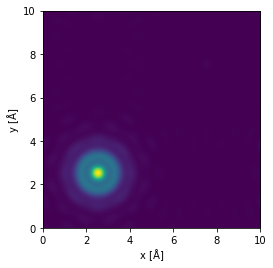

In [21]:
wave.show();

````{note}

The axes convention for arrays representing a wave functions assigns the first axis to the $x$-axis and the second axis to the $y$-axis, and a larger array index implies a larger real-space coordinate. This is different from the convention often used for images. The correct way of displaying an array with `matplotplib` is given below.
    
```python
import matplotlib.pyplot as plt
image = np.abs(waves.array[0]) ** 2
plt.imshow(image.T, extent=[0, waves.extent[0], 0, waves.extent[1]], origin='lower')
```     
````

## Wave function ensembles

(wave_functions:waves)=
## Custom wave functions

Here is how to define a plane wave on a $512 \times 512$ grid with a lateral extent of $10\times 10$ $\mathrm{Å}^2$ and an energy of $300 \ \mathrm{keV}$: